In [2]:
#To generate GIFs
#!pip install imageio
#!pip install git+https://github.com/tensorflow/docs
#!pip install tqdm

import sys
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from keras.datasets import cifar10
from IPython import display
from datetime import datetime
from scipy.linalg import sqrtm
#from tqdm import tqdm

import keras
from keras.models import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.stats import entropy

#import tensorflow_docs.vis.embed as embed


#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import roc_curve, auc
#import seaborn as sns
#from sklearn.metrics import accuracy_score
#tf.debugging.set_log_device_placement(True)

print(sys.prefix,sys.version)

2024-06-10 17:04:46.176782: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 17:04:49.616230: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 17:04:49.629365: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 17:04:53.604384: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/anaconda/envs/ML2_env 3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]


In [3]:
# Ensure TensorFlow is set up to use the GPU if available
gpus = tf.config.list_physical_devices('GPU')
print("List of GPUs:",gpus)
if gpus:
    print("GPU is available and will be used for generation.")
    device_name = '/GPU:0'
    print("CUDA Support:", tf.test.is_built_with_cuda())
else:
    print("GPU is not available. Ensure you have a compatible GPU and TensorFlow setup.")
    device_name = '/CPU:0'

List of GPUs: []
GPU is not available. Ensure you have a compatible GPU and TensorFlow setup.


2024-06-10 17:05:08.724089: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Import & prep dataset

Training data shape:
 (50000, 32, 32, 3) 

Test data shape:
 (10000, 32, 32, 3) 

Training labels shape:
 (50000, 10) 

Test labels shape:
 (10000, 10)


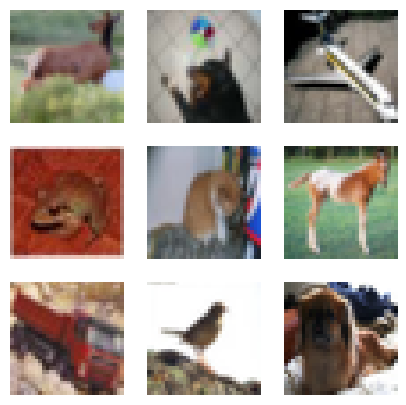

In [4]:
# Import & prep dataset
(train_data, train_labels), (test_data, test_labels) = cifar10.load_data()

print("Training data shape:\n", train_data.shape, "\n")
print("Test data shape:\n", test_data.shape, "\n")

train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

train_data = (train_data - 127.5) / 127.5  # Normalize the images to [-1, 1]
test_data = (test_data - 127.5) / 127.5  # Normalize the images to [-1, 1]

train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

print("Training labels shape:\n", train_labels.shape, "\n")
print("Test labels shape:\n", test_labels.shape)

BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

random_indices = np.random.choice(train_data.shape[0], 9, replace=False)
random_images = train_data[random_indices]

plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow((random_images[i] * 127.5 + 127.5).astype(np.uint8))
    plt.axis('off')
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              206848    
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 8, 8, 128)         0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 128)         147584    
                                                                 
 batch_normalization (Batch  (None, 8, 8, 128)         512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 8, 8, 128)         0

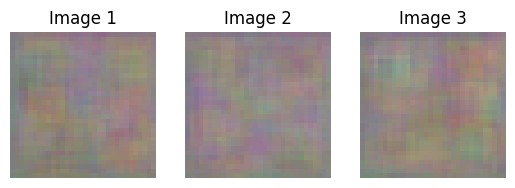

In [5]:
#Source for generator and discriminator models (DCGAN): https://doi.org/10.1007/s11042-019-08600-2

def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(128 * 4 * 4, activation="relu", input_shape=(100,)))
    model.add(layers.Reshape((4, 4, 128)))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(128, kernel_size=3, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(128, kernel_size=3, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(64, kernel_size=3, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    model.add(layers.Conv2D(3, kernel_size=3, padding="same"))
    model.add(layers.Activation("tanh"))

    return model

generator = make_generator_model()
generator.summary()
print("\n\n\n")

for i in range(3):
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)

    plt.subplot(1, 3, i + 1)
    plt.imshow((generated_image[0, :, :, :].numpy() * 127.5 + 127.5).astype(np.uint8))
    plt.title(f"Image {i+1}")
    plt.axis('off')
plt.show()

Discriminator: Hier kann ein aufwändiges CNN rein. 

In [6]:
#Builds on the MNIST model; Starts with a lower kernel amount (one added layer)
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(16, kernel_size=3, strides=2, input_shape=[32, 32, 3], padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(32, kernel_size=3, strides=2, padding="same"))
    model.add(layers.ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size=3, strides=1, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

discriminator = make_discriminator_model()
discriminator.summary()

decision = discriminator(generated_image)
print("\n\n\n")
print (decision)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 16, 16, 16)        448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 16)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 zero_padding2d (ZeroPaddin  (None, 9, 9, 32)          0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 9, 9, 32)          128       
 chNormalization)                                     

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)


noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    generator_losses = []
    discriminator_losses = []
    #accuracy_rates = []

    for epoch in range(epochs):
        start = time.time()
        print(f'Epoch {epoch + 1}/{epochs}')

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            generator_losses.append(gen_loss)
            discriminator_losses.append(disc_loss)

        # Produce images and plot losses at the end of each epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        plot_loss(generator_losses, discriminator_losses, epoch + 1)
        #plot_accuracy(accuracy_rates)

        #calculate accuracy rate for the discriminator
        #accuracy_rate = calculate_accuracy(generator, discriminator)
        #accuracy_rates.append(accuracy_rate)

        print('Time for epoch {} is {:.1f} sec'.format(epoch + 1, time.time()-start))

    # Generate and plot images after the final epoch 
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    plot_loss(generator_losses, discriminator_losses, epochs)

    print('Generator loss after {} epochs: {:.2f}'.format(epoch+1, gen_loss))
    print('Discriminator loss after {} epochs: {:.2f}'.format(epoch+1, disc_loss))
    #print('Accuracy Rate after {} epochs: {:.2f}'.format(epoch+1, accuracy_rate))
    
def plot_loss(generator_losses, discriminator_losses, epoch):
    plt.plot(generator_losses, label='Generator Loss')
    plt.plot(discriminator_losses, label='Discriminator Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Generator and Discriminator Losses')
    plt.legend()
    plt.savefig('losses_gan_cifar10.svg', format='svg', bbox_inches='tight')
    plt.show()

# def plot_accuracy(accuracy_history):
#     plt.figure(figsize=(10, 5))
#     plt.plot(accuracy_history, label='Discriminator Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.title('Discriminator Accuracy Over Epochs')
#     plt.legend()
#     plt.grid(True)
#     plt.show()


def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        #print(type(predictions[i, :, :, :]))
        plt.imshow((predictions[i, :, :, :].numpy() * 127.5 + 127.5).astype(np.uint8))
        plt.axis('off')

    plt.savefig('CIFAR10_gif/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Function to calculate accuracy
# def calculate_accuracy(generator, discriminator, num_samples=10000):
#     real_images = train_data[:num_samples]
#     noise = tf.random.normal([num_samples, noise_dim])
#     fake_images = generator(noise, training=False)

#     real_predictions = discriminator(real_images, training=False)
#     fake_predictions = discriminator(fake_images, training=False)

#     real_labels = tf.ones_like(real_predictions)
#     fake_labels = tf.zeros_like(fake_predictions)

#     real_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(real_predictions), real_labels), tf.float32))
#     fake_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(fake_predictions), fake_labels), tf.float32))

#     accuracy_rate = (real_accuracy + fake_accuracy) / 2.0

#     return accuracy_rate.numpy()


Time for epoch 25 is 271.1 sec


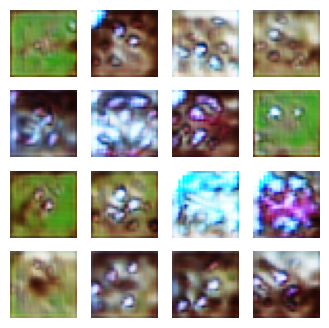

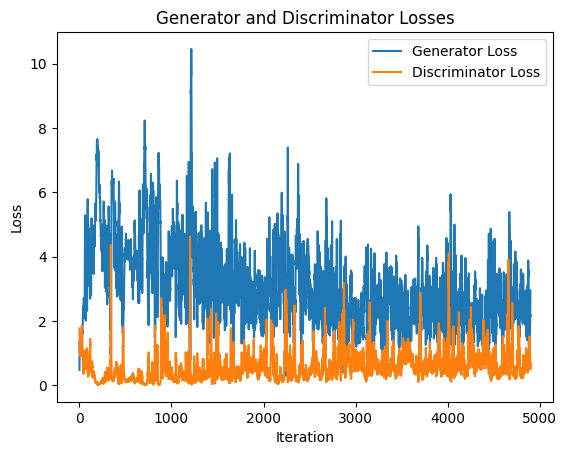

Generator loss after 25 epochs: 2.94
Discriminator loss after 25 epochs: 0.49


In [44]:
EPOCHS = 25

train(train_dataset, EPOCHS)

# Backup the generator and discriminator models
generator.save('CIFAR10_backups/CIFAR10_generator_model_{}epochs_backup_{}.keras'.format(EPOCHS, datetime.now()))
discriminator.save('CIFAR10_backups/CIFAR10_discriminator_model_{}epochs_backup_{}.keras'.format(EPOCHS, datetime.now()))

# Save the generator model for further processing
generator.save('CIFAR10_generator_model_{}epochs.keras'.format(EPOCHS))

Saved 50 generated CIFAR-10 images to CIFAR10_generated_data/GAN_output_CIFAR10_50.npy
Shape of the saved dataset: (50, 32, 32, 3)


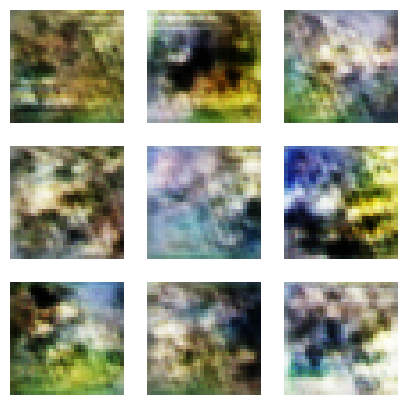

In [14]:
# Load generator from folder
generator = tf.keras.models.load_model('CIFAR10_generator_model_25epochs.keras')

# Define the number of new CIFAR-10 images to generate
n = 50  # You can change this number as needed

# Generate random noise to feed into the generator
random_noise = tf.random.normal([n, noise_dim])

# Generate images from the noise
generated_images = generator(random_noise, training=False)

# Rescale the images from [-1, 1] to [0, 1]
generated_images = (generated_images + 1) / 2.0

# Create the directory if it does not exist
output_dir = 'CIFAR10_generated_data'

# Save the generated images as a NumPy array
output_path = os.path.join(output_dir, f'GAN_output_CIFAR10_{n}.npy')
###np.save(output_path, generated_images.numpy())

print(f'Saved {n} generated CIFAR-10 images to {output_path}')
print(f'Shape of the saved dataset: {generated_images.shape}')

generated_images = np.load(output_path)

random_indices = np.random.choice(generated_images.shape[0], 9, replace=False)
random_images = generated_images[random_indices]

# Plot the random images
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow((random_images[i] * 256).astype(np.uint8))
    plt.axis('off')
plt.show()

In [15]:
# Function to calculate accuracy and error rate
def calculate_accuracy_and_error_rate(generator, discriminator, num_samples=10000):
    # Generate a batch of real and fake images
    real_images = train_data[:num_samples]
    noise = tf.random.normal([num_samples, noise_dim])
    fake_images = generator(noise, training=False)

    # Get discriminator predictions
    real_predictions = discriminator(real_images, training=False)
    fake_predictions = discriminator(fake_images, training=False)

    # Calculate accuracy and error rate
    real_labels = tf.ones_like(real_predictions)
    fake_labels = tf.zeros_like(fake_predictions)

    real_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(real_predictions), real_labels), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(fake_predictions), fake_labels), tf.float32))

    accuracy_rate = (real_accuracy + fake_accuracy) / 2.0
    error_rate = 1.0 - accuracy_rate

    return accuracy_rate.numpy(), error_rate.numpy()

# Calculate accuracy rate and error rate
accuracy_rate, error_rate = calculate_accuracy_and_error_rate(generator, discriminator)

print(f"Accuracy Rate: {accuracy_rate:.4f}")
print(f"Error Rate: {error_rate:.4f}")


2024-06-10 17:06:57.679640: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5242880000 exceeds 10% of free system memory.
2024-06-10 17:06:58.173117: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2621440000 exceeds 10% of free system memory.
2024-06-10 17:07:02.504178: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2621440000 exceeds 10% of free system memory.
2024-06-10 17:07:02.847369: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2621440000 exceeds 10% of free system memory.
2024-06-10 17:07:03.237649: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2621440000 exceeds 10% of free system memory.


Accuracy Rate: 0.4623
Error Rate: 0.5377


In [ ]:
# Load the pre-trained InceptionV3 model
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))

def calculate_inception_score(images, splits=10):
    # Resize images to the size expected by InceptionV3 (75x75) and preprocess them
    images_resized = tf.image.resize(images, [75, 75])
    images_resized = preprocess_input(images_resized)

    # Get the predictions for the resized images
    preds = inception_model.predict(images_resized)
    
    # Calculate the Inception Score
    split_size = images.shape[0] // splits
    scores = []

    for i in range(splits):
        part = preds[i * split_size: (i + 1) * split_size]
        p_y = np.mean(part, axis=0)
        scores.append(np.exp(np.mean([entropy(p, p_y) for p in part])))

    return np.mean(scores), np.std(scores)

# Generate a batch of images from the generator
num_examples_to_generate = 50000
generator = tf.keras.models.load_model('MNIST_generator_model_100epochs.keras')
noise = tf.random.normal([num_examples_to_generate, noise_dim])
generated_images = generator(noise, training=False)
generated_images = (generated_images + 1) / 2.0  # Rescale images to [0, 1]

# Ensure generated images have three channels (for InceptionV3)
generated_images_rgb = np.repeat(generated_images, 3, axis=-1)

# Calculate the Inception Score for the generated images
mean_score, std_score = calculate_inception_score(generated_images_rgb)
print(f"Inception Score: {mean_score:.2f} ± {std_score:.4f}")

938/938 [==============================] - 43s 44ms/step
Inception Score: 1.1504474878311157 ± 0.0011043440317735076


In [ ]:
# Load the pre-trained InceptionV3 model
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))

def calculate_fid(real_images, generated_images):
    # Resize images to the size expected by InceptionV3 (75x75) and preprocess them
    real_images_resized = tf.image.resize(real_images, [75, 75])
    generated_images_resized = tf.image.resize(generated_images, [75, 75])
    real_images_resized = preprocess_input(real_images_resized)
    generated_images_resized = preprocess_input(generated_images_resized)

    # Get the activations for the real and generated images
    act_real = inception_model.predict(real_images_resized)
    act_generated = inception_model.predict(generated_images_resized)

    # Calculate the mean and covariance of the activations
    mu_real, sigma_real = act_real.mean(axis=0), np.cov(act_real, rowvar=False)
    mu_generated, sigma_generated = act_generated.mean(axis=0), np.cov(act_generated, rowvar=False)

    # Calculate the Fréchet distance
    diff = mu_real - mu_generated
    covmean, _ = sqrtm(sigma_real.dot(sigma_generated), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma_real + sigma_generated - 2 * covmean)
    return fid

# Load real images (from test_data)
real_images = (test_data + 1) / 2.0  # Rescale images to [0, 1]
real_images_rgb = np.repeat(real_images, 3, axis=-1)  # Ensure images have three channels

# Generate a batch of images from the generator
num_examples_to_generate = 10000
generator = tf.keras.models.load_model('MNIST_generator_model_100epochs.keras')
noise = tf.random.normal([num_examples_to_generate, noise_dim])
generated_images = generator(noise, training=False)
generated_images = (generated_images + 1) / 2.0  # Rescale images to [0, 1]
generated_images_rgb = np.repeat(generated_images, 3, axis=-1)  # Ensure images have three channels

# Calculate the FID score for the generated images
fid_score = calculate_fid(real_images_rgb, generated_images_rgb)
print(f"FID Score: {fid_score:.2f}")

313/313 [==============================] - 14s 44ms/step
FID Score: 16.13
